<a href="https://colab.research.google.com/github/diegofuentes51/LAB10/blob/main/lab10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Importo las librerías que voy a usar para manipular datos, hacer gráficos y clustering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.compose import ColumnTransformer

# Configuro los gráficos para que se vean en el notebook y con estilo agradable
%matplotlib inline
sns.set(style="whitegrid")

# Cargar el archivo CSV con los datos de vehículos
df = pd.read_csv('/content/vehículos.csv')

# Muestro las primeras filas para conocer cómo están los datos
print("Primeras filas del dataset:")
display(df.head())


Primeras filas del dataset:


,fabricante,modelo,year,desplazamiento,cilindros,transmision,traccion,clase,combustible,consumo,co2,clase_tipo,traccion_tipo,transmision_tipo,combustible_tipo,tamano_motor_tipo,consumo_tipo,co2_tipo,consumo_litros_milla
0,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,17,522.764706,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.222671
1,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
2,AM General,Post Office DJ5 2WD,1985,2.5,4.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,16,555.437500,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.236588
3,AM General,Post Office DJ8 2WD,1985,4.2,6.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
4,ASC Incorporated,GNX,1987,3.8,6.0,Automatic 4-spd,Rear-Wheel Drive,Midsize Cars,Premium,16,555.437500,Coches Medianos,dos,Automatica,Premium,grande,alto,alto,0.236588


In [13]:
# Reviso si hay datos faltantes en cada columna para saber si debo limpiar o imputar algo
print("Datos faltantes por columna:")
print(df.isnull().sum())

# Según las indicaciones, elimino columnas que no voy a usar para el clustering
columnas_a_eliminar = ['fabricante', 'modelo', 'transmision', 'traccion', 'clase', 'combustible', 'consumo']
df = df.drop(columns=columnas_a_eliminar, errors='ignore')

# Verifico que las columnas se eliminaron correctamente
print("\nColumnas actuales después de eliminar:")
print(df.columns)


Datos faltantes por columna:
fabricante                0
modelo                    0
year                      0
desplazamiento            2
cilindros                 3
transmision               2
traccion                789
clase                     0
combustible               0
consumo                   0
co2                       0
clase_tipo                0
traccion_tipo             0
transmision_tipo          0
combustible_tipo          0
tamano_motor_tipo         2
consumo_tipo              0
co2_tipo                  0
consumo_litros_milla      0
dtype: int64

Columnas actuales después de eliminar:
Index(['year', 'desplazamiento', 'cilindros', 'co2', 'clase_tipo',
       'traccion_tipo', 'transmision_tipo', 'combustible_tipo',
       'tamano_motor_tipo', 'consumo_tipo', 'co2_tipo',
       'consumo_litros_milla'],
      dtype='object')


In [14]:
# Identifico las columnas numéricas para detectar outliers solo en variables numéricas
num_cols = df.select_dtypes(include=np.number).columns.tolist()
print(f"Variables numéricas para tratamiento de outliers: {num_cols}")

# Defino una función para eliminar outliers usando el método del rango intercuartílico (IQR)
def eliminar_outliers_iqr(data, columnas):
    df_limpio = data.copy()
    for col in columnas:
        Q1 = df_limpio[col].quantile(0.25)
        Q3 = df_limpio[col].quantile(0.75)
        IQR = Q3 - Q1
        limite_inf = Q1 - 1.5 * IQR
        limite_sup = Q3 + 1.5 * IQR
        filas_antes = df_limpio.shape[0]
        df_limpio = df_limpio[(df_limpio[col] >= limite_inf) & (df_limpio[col] <= limite_sup)]
        filas_despues = df_limpio.shape[0]
        print(f"Para la columna '{col}', eliminé {filas_antes - filas_despues} filas por outliers")
    return df_limpio.reset_index(drop=True)

# Aplico la función para limpiar los outliers univariados
df_sin_outliers = eliminar_outliers_iqr(df, num_cols)

print(f"\nNúmero de filas originales: {df.shape[0]}")
print(f"Número de filas después de eliminar outliers: {df_sin_outliers.shape[0]}")


Variables numéricas para tratamiento de outliers: ['year', 'desplazamiento', 'cilindros', 'co2', 'consumo_litros_milla']
Para la columna 'year', eliminé 0 filas por outliers
Para la columna 'desplazamiento', eliminé 45 filas por outliers
Para la columna 'cilindros', eliminé 693 filas por outliers
Para la columna 'co2', eliminé 1164 filas por outliers
Para la columna 'consumo_litros_milla', eliminé 30 filas por outliers

Número de filas originales: 36791
Número de filas después de eliminar outliers: 34859


In [15]:
# Identifico ahora las variables categóricas para hacer la dumización (one-hot encoding)
cat_cols = df_sin_outliers.select_dtypes(include='object').columns.tolist()
print(f"Variables categóricas para dumización: {cat_cols}")

# Preparo un transformador que escale numéricas y convierta categóricas en variables dummy
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
    ])

# Aplico la transformación y guardo el resultado en X
X = preprocessor.fit_transform(df_sin_outliers)

print(f"\nLa matriz final tiene forma: {X.shape} (filas, columnas) después de escalamiento y dumización")


Variables categóricas para dumización: ['clase_tipo', 'traccion_tipo', 'transmision_tipo', 'combustible_tipo', 'tamano_motor_tipo', 'consumo_tipo', 'co2_tipo']

La matriz final tiene forma: (34859, 29) (filas, columnas) después de escalamiento y dumización


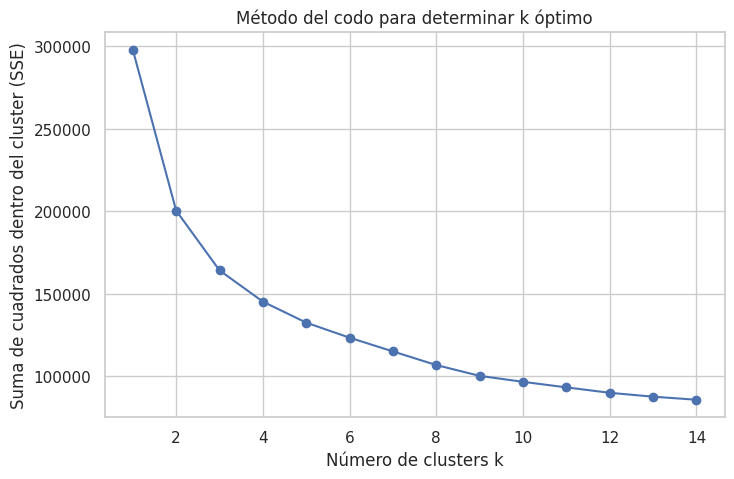

In [16]:
# Calculo la suma de cuadrados dentro de los clusters (SSE) para varios valores de k
sse = []
k_values = range(1, 15)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Grafico el método del codo para elegir el número adecuado de clusters
plt.figure(figsize=(8,5))
plt.plot(k_values, sse, marker='o')
plt.title('Método del codo para determinar k óptimo')
plt.xlabel('Número de clusters k')
plt.ylabel('Suma de cuadrados dentro del cluster (SSE)')
plt.grid(True)
plt.show()


In [17]:
# Defino k óptimo (por ejemplo, 8 según el método del codo)
k_optimo = 8

# Aplico KMeans con k = 8
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X)

# Agrego la columna 'cluster' al dataframe sin outliers para analizar los grupos
df_sin_outliers['cluster'] = clusters

# Muestro características promedio de las variables numéricas por cluster para entenderlos
print("Características promedio de variables numéricas por cluster:")
display(df_sin_outliers.groupby('cluster')[num_cols].mean())


Características promedio de variables numéricas por cluster:


,year,desplazamiento,cilindros,co2,consumo_litros_milla
cluster,,,,,
0,2009.973948,3.308489,5.922360,444.460659,0.189191
1,1998.754140,5.275847,7.894013,631.470093,0.266778
2,2012.378777,2.038806,4.096360,326.417524,0.139047
3,1998.194033,2.221559,4.191723,406.227193,0.172918
4,2005.404923,5.003477,7.998154,508.928416,0.215560
5,1996.449706,3.698013,5.899902,561.950797,0.239371
6,1991.385074,1.769238,3.956413,334.559916,0.141573
7,1992.372632,2.766105,5.110622,469.771819,0.199655


In [18]:
# Calculo índices de evaluación interna para medir la calidad del clustering

silhouette = silhouette_score(X, clusters)
calinski = calinski_harabasz_score(X, clusters)
davies = davies_bouldin_score(X, clusters)

print(f"Índice Silhouette: {silhouette:.4f}  (más cerca de 1, mejor agrupamiento)")
print(f"Índice Calinski-Harabasz: {calinski:.4f}  (mayor valor, mejor separación)")
print(f"Índice Davies-Bouldin: {davies:.4f}  (más bajo, mejor agrupamiento)")


Índice Silhouette: 0.2160  (más cerca de 1, mejor agrupamiento)
Índice Calinski-Harabasz: 8898.1998  (mayor valor, mejor separación)
Índice Davies-Bouldin: 1.5006  (más bajo, mejor agrupamiento)


In [19]:
# Si la variable 'clase_tipo' está disponible, calculo métricas de evaluación externa

if 'clase_tipo' in df_sin_outliers.columns:
    etiquetas_reales = df_sin_outliers['clase_tipo']
    ari = adjusted_rand_score(etiquetas_reales, clusters)
    nmi = normalized_mutual_info_score(etiquetas_reales, clusters)
    print(f"Adjusted Rand Index (ARI): {ari:.4f}  (valores cercanos a 1 indican buena concordancia)")
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}  (valores cercanos a 1 indican buena concordancia)")
else:
    print("La variable 'clase_tipo' no está disponible para evaluación externa.")


Adjusted Rand Index (ARI): 0.0664  (valores cercanos a 1 indican buena concordancia)
Normalized Mutual Information (NMI): 0.1489  (valores cercanos a 1 indican buena concordancia)
